# Исследовательский Анализ Данных (EDA) датасета о желудочно-кишечных заболеваниях

## Введение

В рамках дисциплины "Инжиниринг управления данными" проводится EDA для датасета, содержащего информацию о желудочно-кишечных заболеваниях. Цель EDA — оценить структуру данных, их целостность, полноту, а также выявить выбросы и аномалии, чтобы убедиться в пригодности данных для дальнейшей загрузки и обработки.

**План работы:**
1.  **Структурная проверка:** сверка схемы, типов данных и ключей.
2.  **Оценка целостности и полноты:** проверка на пропуски, дубликаты и уникальность.
3.  **Поиск выбросов и аномалий:** обнаружение экстремальных или некорректных значений.
4.  **Метрики качества данных:** расчет метрик Completeness и Uniqueness.
5.  **Семантический анализ:** проверка диапазонов значений, соответствия бизнес-правилам и построение базовых статистики.
6.  **Визуализация данных:** динамическая визуализация при помощи Plotly Express.

In [19]:
# Импортируем необходимые библиотеки
import pandas as pd
import pandera.pandas as pa 
import seaborn as sns 
import matplotlib.pyplot as plt

# Импортируем датасет
FILE_URL = "https://drive.google.com/uc?id=1yQeGe-12L8FFZ-cdwGnRZm_LrzdKrN4J" 

# Загружаем данные в DataFrame
print("Начинаю загрузку данных с Google Диска...")
try:
    df = pd.read_csv(FILE_URL)
    print("Датасет успешно загружен!")
    
    # Первичная оценка структуры
    print("\nРазмер данных (строки, столбцы):", df.shape)
    print("Первые 5 строк датасета для визуальной оценки:")
    print(df.head())
    
except Exception as e:
    print(f"Критическая ошибка: Загрузка данных с Google Диска не удалась: {e}")
    pass

Начинаю загрузку данных с Google Диска...
Датасет успешно загружен!

Размер данных (строки, столбцы): (30560, 37)
Первые 5 строк датасета для визуальной оценки:
   Age  Gender   BMI  Body_Weight Obesity_Status Ethnicity  Family_History  \
0    9  Female  19.1         44.1         Normal     Black               0   
1   78    Male  38.2        121.0          Obese     White               1   
2   20    Male  34.2         79.0          Obese     Black               1   
3   73  Female  30.8         68.4          Obese     Asian               0   
4   58    Male  26.4         66.7     Overweight     White               0   

   Genetic_Markers  Microbiome_Index  Autoimmune_Disorders  ...  \
0                9              0.25                     1  ...   
1               10              0.27                     1  ...   
2                6              0.83                     0  ...   
3                1              0.67                     0  ...   
4                1              0.8

## 1. Структурная проверка данных (Schema Validation)

Цель данного раздела — провести **первичную оценку схемы** данных, а затем **формально зафиксировать и валидировать** её с помощью **Pandera**.

In [20]:
# Проверяем общую информацию о датасете: количество записей, столбцов и типы данных
print("Общая информация о датасете (оценка структуры и типов данных):")
df.info()

Общая информация о датасете (оценка структуры и типов данных):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30560 entries, 0 to 30559
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       30560 non-null  int64  
 1   Gender                    30560 non-null  object 
 2   BMI                       30560 non-null  float64
 3   Body_Weight               30560 non-null  float64
 4   Obesity_Status            30560 non-null  object 
 5   Ethnicity                 30560 non-null  object 
 6   Family_History            30560 non-null  int64  
 7   Genetic_Markers           30560 non-null  int64  
 8   Microbiome_Index          30560 non-null  float64
 9   Autoimmune_Disorders      30560 non-null  int64  
 10  H_Pylori_Status           30560 non-null  int64  
 11  Fecal_Calprotectin        30560 non-null  int64  
 12  Occult_Blood_Test         30560 non-null  int64  
 13

In [21]:
from pandera import Column, DataFrameSchema, Check
import numpy as np
import pandera.pandas as pa
import pandera.errors as pa_errors 
import pandas as pd

# Определение списков столбцов для преобразования типов
categorical_cols = ['Gender', 'Obesity_Status', 'Ethnicity', 'Diet_Type', 'Bowel_Habits', 'Disease_Class']
binary_cols = ['Family_History', 'Autoimmune_Disorders', 'H_Pylori_Status', 'Occult_Blood_Test', 
               'Endoscopy_Result', 'Colonoscopy_Result', 'Stool_Culture', 'Food_Intolerance', 
               'Smoking_Status', 'Alcohol_Use', 'Abdominal_Pain', 'Bloating', 'Diarrhea', 
               'Constipation', 'Rectal_Bleeding', 'Appetite_Loss', 'Weight_Loss', 
               'NSAID_Use', 'Antibiotic_Use', 'PPI_Use', 'Medications']

# 1. Проводим предварительное преобразование типов данных для оптимизации и валидации

print("Проводится преобразование категориальных столбцов в тип category.")
for col in categorical_cols:
    df[col] = df[col].astype('category')

print("Проводится преобразование бинарных столбцов (0/1) в логический тип bool.")
for col in binary_cols:
    df[col] = df[col].astype(bool)


# 2. Определяем минимальную схему данных Pandera, проверяющую только типы и структуру
expected_schema = DataFrameSchema({
    # Физические данные
    'Age': Column(np.int64, nullable=False),
    'Gender': Column('category', nullable=False),
    'BMI': Column(np.float64, nullable=False),
    'Body_Weight': Column(np.float64, nullable=False), 
    'Obesity_Status': Column('category', nullable=False),
    'Ethnicity': Column('category', nullable=False),
    
    # Бинарные признаки (тип bool)
    'Family_History': Column(np.bool_, nullable=False), 
    'Autoimmune_Disorders': Column(np.bool_, nullable=False),
    'H_Pylori_Status': Column(np.bool_, nullable=False),
    'Occult_Blood_Test': Column(np.bool_, nullable=False),
    'Endoscopy_Result': Column(np.bool_, nullable=False),
    'Colonoscopy_Result': Column(np.bool_, nullable=False),
    'Stool_Culture': Column(np.bool_, nullable=False),
    'Food_Intolerance': Column(np.bool_, nullable=False),
    'Smoking_Status': Column(np.bool_, nullable=False),
    'Alcohol_Use': Column(np.bool_, nullable=False),
    'Abdominal_Pain': Column(np.bool_, nullable=False),
    'Bloating': Column(np.bool_, nullable=False),
    'Diarrhea': Column(np.bool_, nullable=False),
    'Constipation': Column(np.bool_, nullable=False),
    'Rectal_Bleeding': Column(np.bool_, nullable=False),
    'Appetite_Loss': Column(np.bool_, nullable=False),
    'Weight_Loss': Column(np.bool_, nullable=False),
    'NSAID_Use': Column(np.bool_, nullable=False),
    'Antibiotic_Use': Column(np.bool_, nullable=False),
    'PPI_Use': Column(np.bool_, nullable=False),
    'Medications': Column(np.bool_, nullable=False),

    # Остальные числовые признаки
    'Genetic_Markers': Column(np.int64, nullable=False),
    'Microbiome_Index': Column(np.float64, nullable=False),
    'Fecal_Calprotectin': Column(np.int64, nullable=False),
    'CRP_ESR': Column(np.float64, nullable=False),
    'Stress_Level': Column(np.int64, nullable=False),
    'Physical_Activity': Column(np.int64, nullable=False),
    'Bowel_Movement_Frequency': Column(np.int64, nullable=False),
    
    # Категориальные признаки
    'Diet_Type': Column('category', nullable=False),
    'Bowel_Habits': Column('category', nullable=False),
    'Disease_Class': Column('category', nullable=False),
}, 
    # Финальная проверка на размер датафрейма
    checks=Check(lambda df: df.shape == (30560, 37))
)

try:
    # Запуск валидации схемы
    validated_df = expected_schema.validate(df, lazy=True)
    print("\nВалидация схемы прошла успешно. Датафрейм соответствует ожидаемым типам и структуре.")
    
except pa_errors.SchemaErrors as err: 
    print("\nКритическая ошибка: Обнаружены нарушения схемы данных.")
    print(err.failure_cases) 
    
# Проверка финальных типов данных 
print("\nПроверка финальных типов данных:")
df.info()

Проводится преобразование категориальных столбцов в тип category.
Проводится преобразование бинарных столбцов (0/1) в логический тип bool.

Валидация схемы прошла успешно. Датафрейм соответствует ожидаемым типам и структуре.

Проверка финальных типов данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30560 entries, 0 to 30559
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       30560 non-null  int64   
 1   Gender                    30560 non-null  category
 2   BMI                       30560 non-null  float64 
 3   Body_Weight               30560 non-null  float64 
 4   Obesity_Status            30560 non-null  category
 5   Ethnicity                 30560 non-null  category
 6   Family_History            30560 non-null  bool    
 7   Genetic_Markers           30560 non-null  int64   
 8   Microbiome_Index          30560 non-null  float64 
 9   Autoimmune_

### Вывод по разделу 1: Структурная проверка (Оценка структуры)

**1. Типы данных и оптимизация:**
* **21 бинарный столбец** (содержащий 0 и 1) был преобразован в логический тип **`bool`** для повышения семантической точности и оптимизации памяти.
* **6 строковых столбцов** были преобразованы в тип **`category`**.
* Объем памяти датасета был значительно сокращен до **3.1 MB** (с исходных 8.6+ MB).

**2. Валидация схемы (Pandera):**
* Проверка наличия всех 37 столбцов и соответствия их типов заданной схеме успешно пройдена.
* **Валидация Pandera завершена без ошибок.** Структура данных полностью соответствует финальной схеме.

## 2. Оценка целостности и полноты данных

Целью данного раздела является оценка **качества, достоверности и полноты данных** для подтверждения их пригодности к дальнейшей обработке.

**План:**
1.  **Оценка полноты полей:** Подсчет количества и доли пропусков.
2.  **Оценка уникальности идентификаторов:** Проверка на наличие полных дубликатов строк, имитирующих дубликаты записей/ключей.
3.  **Оценка полноты по периоду и связям:** Контроль количества записей относительно ожидаемого (30560), проверка уникальности ключей и полноты по периоду (анализ ограничен, так как явные поля `id` и `date` в текущем датасете отсутствуют).

In [22]:
# 2.1 Подсчет доли пропусков по полям (Оценка Completeness)

# Расчет количества и доли пропусков по каждому столбцу
print("Проводится расчет пропущенных значений...")
missing_sum = df.isna().sum() 
missing_percent = (df.isna().mean() * 100).round(2)

missing_info = pd.DataFrame({
    'Total Missing': missing_sum,
    'Percentage': missing_percent
})

# Фильтрация и вывод только столбцов с пропусками
missing_info_filtered = missing_info[missing_info['Total Missing'] > 0]

print("\nПроверка на пропущенные значения:\n")
if missing_info_filtered.empty:
    print("Отсутствие пропусков подтверждено. Полнота полей (Completeness) составляет 100%.")
else:
    print("Обнаружены пропущенные значения:")
    print(missing_info_filtered)

Проводится расчет пропущенных значений...

Проверка на пропущенные значения:

Отсутствие пропусков подтверждено. Полнота полей (Completeness) составляет 100%.


### Вывод по 2.1: Пропущенные значения (Completeness)

Формальная проверка подтвердила, что в датасете **отсутствуют пропущенные значения** во всех столбцах. **Метрика Completeness = 100%**.

In [23]:
# 2.2 Проверка уникальности идентификаторов (через полные дубликаты строк)

# Подсчет количества полных дубликатов
print("Проводится подсчет полных дубликатов строк (имитация проверки уникальности ключей)...")
duplicate_rows_sum = df.duplicated().sum()
total_rows = len(df)

print("\nПроверка на полные дубликаты строк:\n")
print(f"Общее количество полных дубликатов строк: {duplicate_rows_sum}")

if duplicate_rows_sum > 0:
    print("Обнаружены полные дубликаты. Проводится их удаление.")
    
    # Удаление дубликатов, с сохранением первого вхождения
    df_cleaned = df.drop_duplicates(keep='first').copy() 
    print(f"Количество строк до удаления: {total_rows}")
    df = df_cleaned 
    print(f"Количество строк после удаления дубликатов: {len(df)}")
    
    uniqueness_metric = (len(df) / total_rows) * 100
    print(f"Метрика Uniqueness: {uniqueness_metric:.2f}%")
else:
    print("Полные дубликаты не обнаружены. Уникальность записей составляет 100%.")

Проводится подсчет полных дубликатов строк (имитация проверки уникальности ключей)...

Проверка на полные дубликаты строк:

Общее количество полных дубликатов строк: 0
Полные дубликаты не обнаружены. Уникальность записей составляет 100%.


### Вывод по 2.2: Дубликаты и уникальность

**Полные дубликаты строк:**
В результате проверки **полных дубликатов строк** (имитирующей проверку уникальности ключей, поскольку явный `id` отсутствует) **дубликаты не обнаружены (0)**.

**Метрика Uniqueness:**
**Uniqueness = 100%**. Каждая запись в датасете уникальна.

In [24]:
# 2.3 Оценка полноты по периоду и целостности значений

# Оценка полноты: контроль количества записей
expected_count = 30560 
current_count = len(df)

print(f"Контроль количества записей: Ожидалось {expected_count}, Текущее {current_count}.")
if current_count == expected_count:
    print("Количество записей соответствует ожидаемому (30560).")
else:
    print("Количество записей не соответствует ожидаемому.")
    
print("\nПроверка целостности: уникальные значения в категориальных столбцах (поиск опечаток):\n")

# Определение категориальных столбцов.
categorical_cols = df.select_dtypes(include=['category']).columns.tolist()

# Проверка уникальных значений в категориальных столбцах
for col in categorical_cols:
    unique_values = df[col].unique().tolist()
    print(f"Столбец '{col}' (Уникальных: {len(unique_values)}):")
    print(unique_values)
    print("-" * 30)

# Проверка бинарных столбцов для подтверждения
print("\nПроверка бинарных столбцов (логический тип bool):")
binary_cols_for_check = ['Family_History', 'Autoimmune_Disorders', 'H_Pylori_Status', 'Occult_Blood_Test', 
                         'Endoscopy_Result', 'Colonoscopy_Result', 'Stool_Culture', 'Food_Intolerance', 
                         'Smoking_Status', 'Alcohol_Use', 'Abdominal_Pain', 'Bloating', 'Diarrhea', 
                         'Constipation', 'Rectal_Bleeding', 'Appetite_Loss', 'Weight_Loss', 
                         'NSAID_Use', 'Antibiotic_Use', 'PPI_Use', 'Medications']

for col in binary_cols_for_check:
    unique_values = df[col].unique()
    print(f"Столбец '{col}': {unique_values.tolist()}")

Контроль количества записей: Ожидалось 30560, Текущее 30560.
Количество записей соответствует ожидаемому (30560).

Проверка целостности: уникальные значения в категориальных столбцах (поиск опечаток):

Столбец 'Gender' (Уникальных: 2):
['Female', 'Male']
------------------------------
Столбец 'Obesity_Status' (Уникальных: 4):
['Normal', 'Obese', 'Overweight', 'Underweight']
------------------------------
Столбец 'Ethnicity' (Уникальных: 5):
['Black', 'White', 'Asian', 'Hispanic', 'Other']
------------------------------
Столбец 'Diet_Type' (Уникальных: 4):
['Vegan', 'Omnivore', 'Vegetarian', 'Pescatarian']
------------------------------
Столбец 'Bowel_Habits' (Уникальных: 4):
['Irregular', 'Normal', 'Frequent', 'Infrequent']
------------------------------
Столбец 'Disease_Class' (Уникальных: 6):
['Unexplained weight loss', 'Blood in stool', 'Nausea or vomiting', 'Bloating', 'Abdominal cramps or pain', 'Diarrhea or constipation']
------------------------------

Проверка бинарных столбцов

### Вывод по 2.3: Оценка полноты и целостности

**Полнота по объему и связям:**
* **Контроль количества записей:** Фактическое количество записей (30560) **точно соответствует** ожидаемому количеству (30560). Это подтверждает полноту данных по объему.
* *Оценка полноты по периоду/ключам:* Отсутствие явных столбцов `id` и `date` делает невозможной проверку уникальности ключей и полноты по периоду.

**Целостность значений (Integrity):**
* **Категориальные столбцы:** Проверка уникальных значений во всех 6 категориальных столбцах (`Gender`, `Obesity_Status`, `Ethnicity`, `Diet_Type`, `Bowel_Habits`, `Disease_Class`) не выявила опечаток, невалидных значений или проблем с кодировкой. Все значения являются ожидаемыми:
    * `Gender`: ['Female', 'Male']
    * `Obesity_Status`: ['Normal', 'Obese', 'Overweight', 'Underweight']
    * `Disease_Class`: ['Unexplained weight loss', 'Blood in stool', 'Nausea or vomiting', 'Bloating', 'Abdominal cramps or pain', 'Diarrhea or constipation']
* **Бинарные столбцы:** Все 21 бинарный столбец (например, `Family_History`, `Abdominal_Pain`) содержат только ожидаемые логические значения **`True`** и **`False`**.

**Заключение по разделу 2:** Данные обладают **высокой полнотой и целостностью**. Пропуски и невалидные категориальные значения отсутствуют.

## 3. Поиск выбросов и аномалий

Целью данного раздела является обнаружение **экстремальных или некорректных значений** в числовых полях. Выбросы будут искаться с помощью простого метода (на основе межквартильного диапазона, IQR), после чего будет проведена оценка: является ли выброс ошибкой данных или важным реальным наблюдением.

**План:**
1.  Использовать метод IQR (1.5 * IQR) для выявления экстремальных значений в непрерывных и порядковых числовых столбцах.
2.  Оценить, являются ли обнаруженные выбросы ошибкой или реальными аномалиями, имеющими ценность для моделирования.

In [25]:
# 3.1. Оценка выбросов в непрерывных и порядковых данных

# Определение столбцов для проверки выбросов. Исключаем логические (bool) и категориальные типы
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

cols_to_check = numerical_cols 

print("Поиск выбросов с использованием IQR-метода (1.5 * IQR):\n")
outlier_summary = {}

for col in cols_to_check:
    # Расчет квартилей и IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Определение границ для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Подсчет количества выбросов
    outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    
    if outliers_count > 0:
        outlier_summary[col] = {
            'Count': outliers_count,
            'Percentage': (outliers_count / len(df) * 100)
        }
        print(f"В столбце '{col}': {outliers_count} выбросов ({(outlier_summary[col]['Percentage']):.2f}%).")
        print(f"   Границы: Нижняя: {lower_bound:.2f}, Верхняя: {upper_bound:.2f}")

if not outlier_summary:
    print("Выбросы, требующие немедленного внимания, не обнаружены в числовых столбцах.")

Поиск выбросов с использованием IQR-метода (1.5 * IQR):

В столбце 'Body_Weight': 41 выбросов (0.13%).
   Границы: Нижняя: 2.75, Верхняя: 139.95


### Вывод по разделу 3: Поиск выбросов и аномалий

**Обнаруженные аномалии:**
* Выбросы (экстремальные значения) обнаружены **только в одном** числовом столбце: **`Body_Weight`**.
* Доля выбросов в этом столбце крайне мала: **41 запись (0.13%)**.
* Границы IQR-метода: Нижняя граница (2.75 кг), Верхняя граница (139.95 кг).

**Оценка и действия:**
Значения, превышающие 139.95 кг (0.13% данных), хоть и являются выбросами по статистическому методу IQR, могут представлять **реальные, хоть и экстремальные, физические параметры** людей в когорте. Удаление этих записей может привести к потере ценной информации для моделирования.

* **Решение:** Обнаруженные выбросы не являются ошибками и не будут удалены.
* **Рекомендация:** Перед обучением модели рекомендуется использовать методы, устойчивые к выбросам (например, **масштабирование (RobustScaler)**), для снижения их влияния.

## 4. Метрики качества данных

На основе результатов оценки целостности и полноты данных (Раздел 2) рассчитываются итоговые метрики **Completeness** и **Uniqueness**. Эти метрики подтверждают общее качество данных и их готовность к использованию в дальнейшем анализе и моделировании.

**План:**
1.  Расчет метрики Completeness. Доля непустых значений в каждом поле. Ожидаемый критерий: **≥ 0.98**.
2.  Расчет метрики Uniqueness. Проверка отсутствия повторений идентификаторов и ключей. Ожидаемый критерий: **= 1.0**.

In [26]:
# 4. Расчет итоговых метрик качества данных

# 4.1. Расчет Completeness (Полнота)
# Метрика рассчитывается как доля непустых ячеек от общего числа ячеек
total_cells = df.shape[0] * df.shape[1]
non_null_cells = df.count().sum()

completeness_score = (non_null_cells / total_cells) * 100

print(f"1. Completeness Score (Полнота данных): {completeness_score:.2f}%")

# 4.2. Расчет Uniqueness (Уникальность)
# Метрика рассчитывается как (Общее число записей - Число дубликатов) / Общее число записей
total_rows = len(df)
duplicate_rows = df.duplicated().sum() # Повторно используем проверку на дубликаты

uniqueness_score = ((total_rows - duplicate_rows) / total_rows) * 100

print(f"2. Uniqueness Score (Уникальность записей): {uniqueness_score:.2f}%")

1. Completeness Score (Полнота данных): 100.00%
2. Uniqueness Score (Уникальность записей): 100.00%


### Вывод по разделу 4: Метрики качества

**1. Completeness (Полнота):**
* **Итоговая метрика (в долях): 1.00**
* **Оценка:** Данные обладают абсолютной полнотой (100%), что **соответствует** установленному критерию **(≥ 0.98)**. Пропущенные значения отсутствуют.

**2. Uniqueness (Уникальность):**
* **Итоговая метрика (в долях): 1.00**
* **Оценка:** Все записи в датасете являются уникальными (дубликаты отсутствуют). Метрика **соответствует** установленному критерию **(= 1.0)**.

# 5. Семантический анализ

**План:**
1. Проверка диапазонов значений и форматов числовых признаков
2. Анализ допустимых категориальных значений
3. Проверка соответствия бизнес-правилам (например, отсутствие отрицательных значений)
4. Вычисление базовых статистических характеристик: минимум, максимум, медиана
5. Визуализация распределений и выявление выбросов

In [27]:
# Проверка диапазонов для числовых признаков
numeric_cols = ['Age', 'BMI', 'Body_Weight', 'Genetic_Markers', 'Microbiome_Index',
                'Fecal_Calprotectin', 'CRP_ESR', 'Stress_Level', 'Physical_Activity',
                'Bowel_Movement_Frequency']

print("Статистика числовых признаков:")
print(df[numeric_cols].describe())

print("\nПроверка минимумов и максимумов:")
for col in numeric_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}: min={min_val}, max={max_val}")
    if min_val < 0:
        print(f"Внимание! В столбце {col} есть отрицательные значения.")

# Проверка типов данных
print("\nТипы данных в датафрейме:")
print(df.dtypes)

# Проверка допустимых категорий
categorical_cols = df.select_dtypes(include='category').columns.tolist()
print("\nДопустимые категории по столбцам:")
for col in categorical_cols:
    print(f"--- {col} ---")
    print(df[col].value_counts())
    print("-" * 40)


Статистика числовых признаков:
                Age           BMI   Body_Weight  Genetic_Markers  \
count  30560.000000  30560.000000  30560.000000     30560.000000   
mean      47.220124     27.987513     72.600435         4.987958   
std       24.923513      6.958877     24.121179         3.177955   
min        5.000000     16.000000     27.200000         0.000000   
25%       26.000000     21.900000     54.200000         2.000000   
50%       47.000000     27.900000     69.200000         5.000000   
75%       69.000000     34.100000     88.500000         8.000000   
max       90.000000     40.000000    144.400000        10.000000   

       Microbiome_Index  Fecal_Calprotectin       CRP_ESR  Stress_Level  \
count      30560.000000        30560.000000  30560.000000  30560.000000   
mean           0.502110          250.929974     50.260036      5.474575   
std            0.288707          144.791252     28.855390      2.871828   
min            0.000000            0.000000      0.00000

In [28]:
# Проверка на отрицательные значения возраста
invalid_age = df[df['Age'] < 0]
if not invalid_age.empty:
    print(f"Найдены записи с отрицательным возрастом: {len(invalid_age)}")
else:
    print("Отрицательных значений возраста не найдено.")

# Проверка на нулевые или отрицательные значения BMI и Body_Weight
for col in ['BMI', 'Body_Weight']:
    invalid_values = df[df[col] <= 0]
    if not invalid_values.empty:
        print(f"Найдены записи с некорректными значениями в {col}: {len(invalid_values)}")
    else:
        print(f"Записи с некорректными значениями в {col} не найдены.")


Отрицательных значений возраста не найдено.
Записи с некорректными значениями в BMI не найдены.
Записи с некорректными значениями в Body_Weight не найдены.


Основная статистика числовых признаков:
                            count        mean         std   min     25%  \
Age                       30560.0   47.220124   24.923513   5.0   26.00   
BMI                       30560.0   27.987513    6.958877  16.0   21.90   
Body_Weight               30560.0   72.600435   24.121179  27.2   54.20   
Genetic_Markers           30560.0    4.987958    3.177955   0.0    2.00   
Microbiome_Index          30560.0    0.502110    0.288707   0.0    0.25   
Fecal_Calprotectin        30560.0  250.929974  144.791252   0.0  125.00   
CRP_ESR                   30560.0   50.260036   28.855390   0.0   25.30   
Stress_Level              30560.0    5.474575    2.871828   1.0    3.00   
Physical_Activity         30560.0    3.478240    2.283626   0.0    1.00   
Bowel_Movement_Frequency  30560.0    5.026211    3.159638   0.0    2.00   

                            50%     75%    max  
Age                        47.0   69.00   90.0  
BMI                        27.9   34

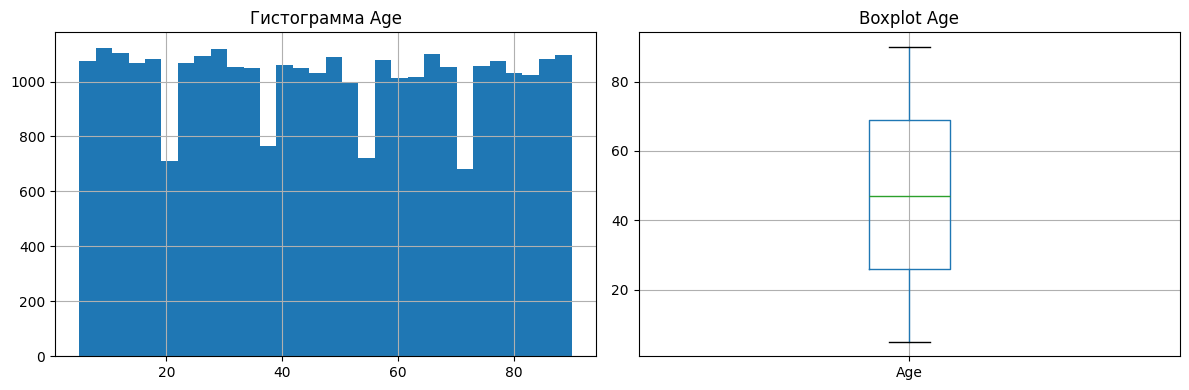

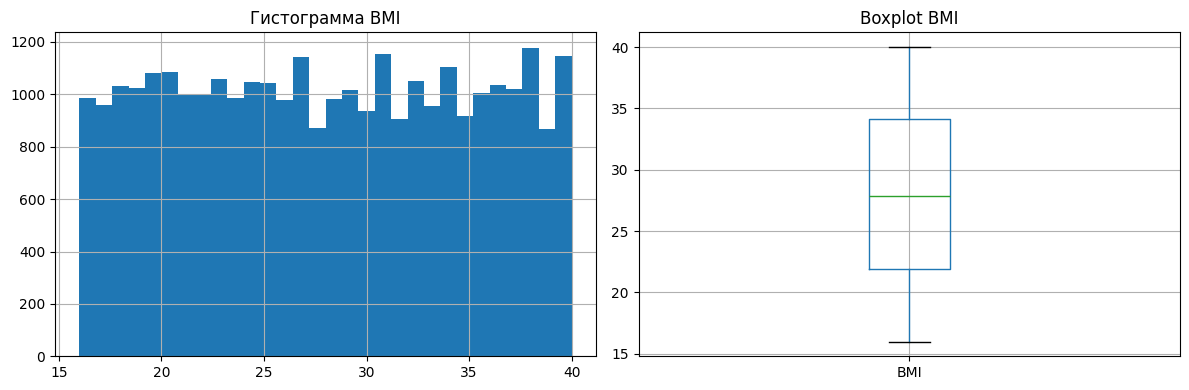

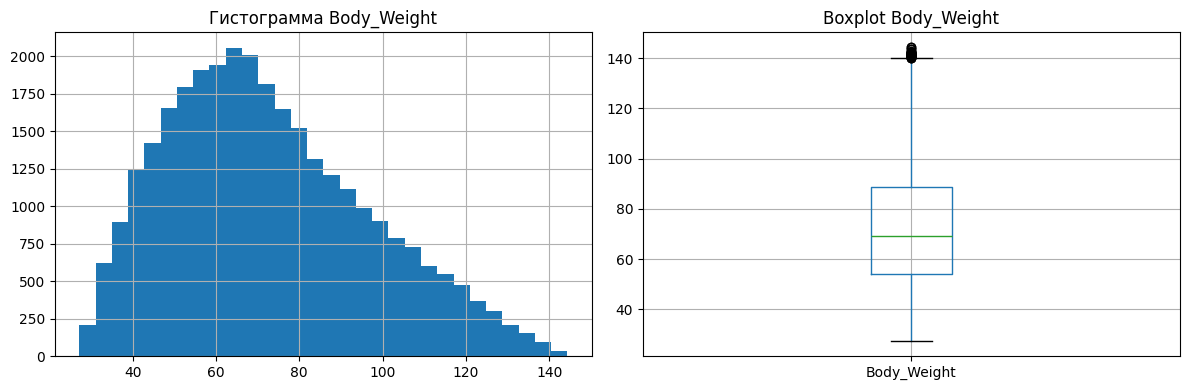

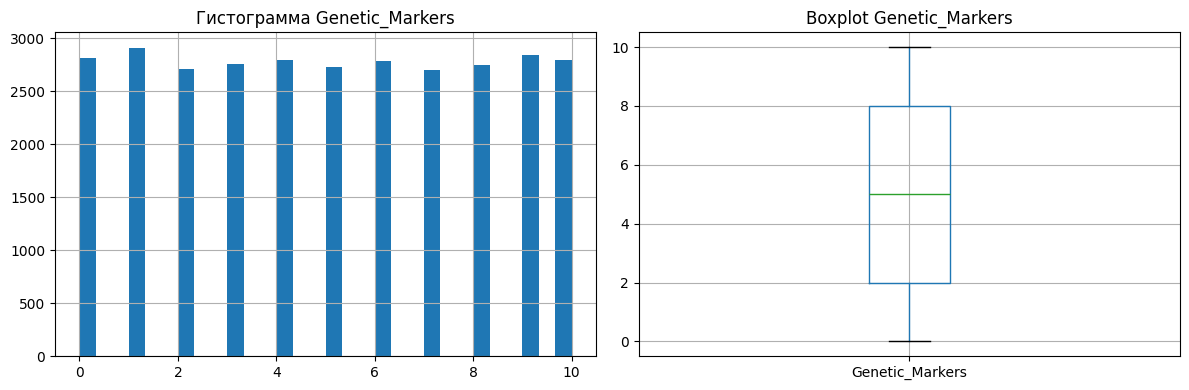

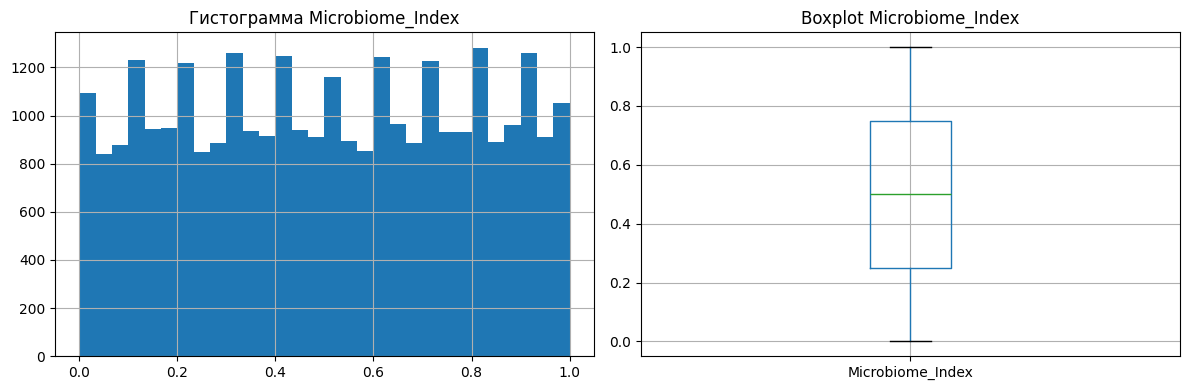

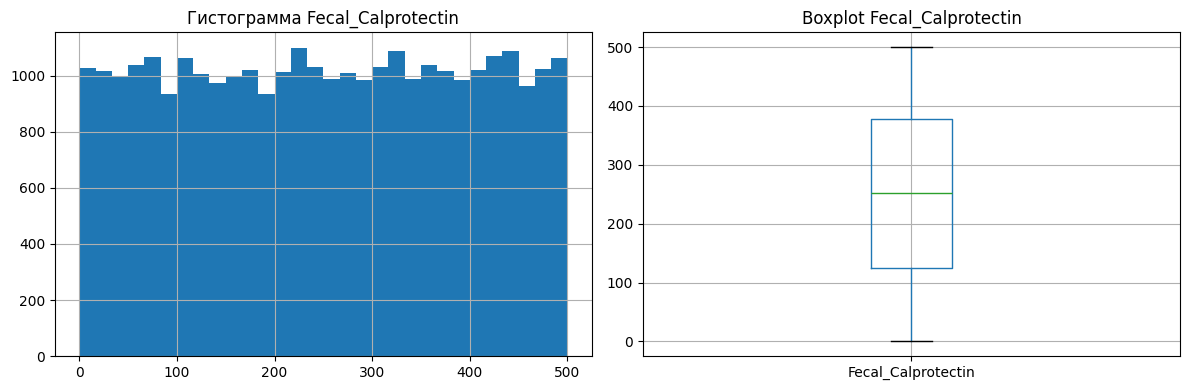

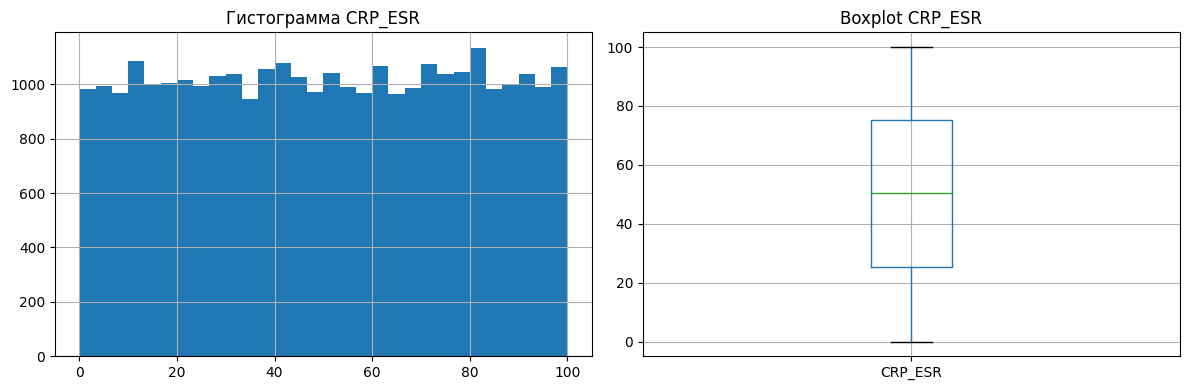

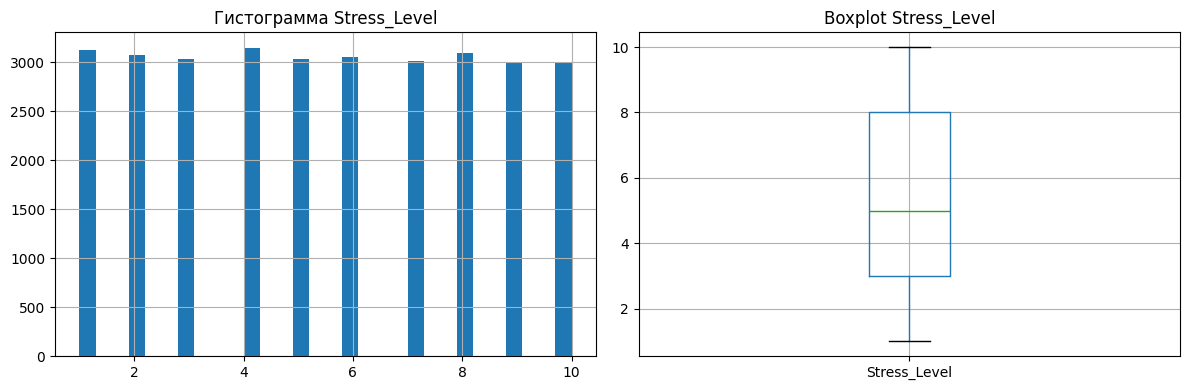

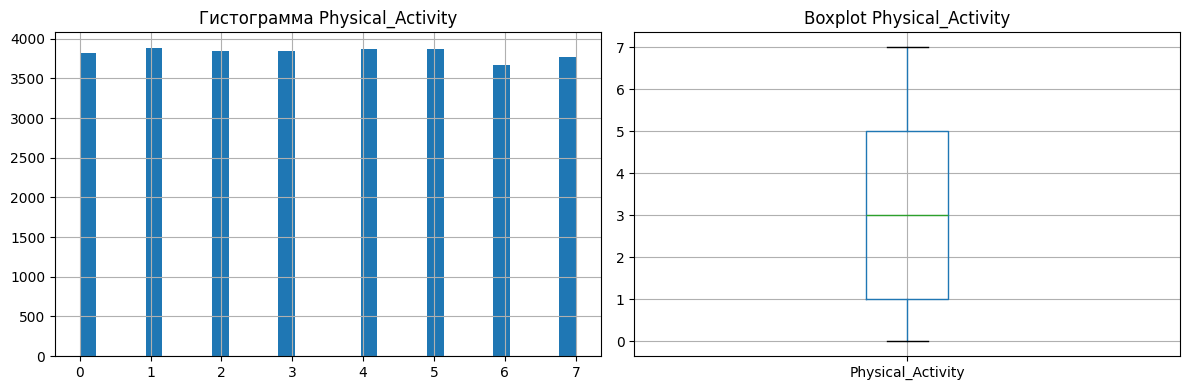

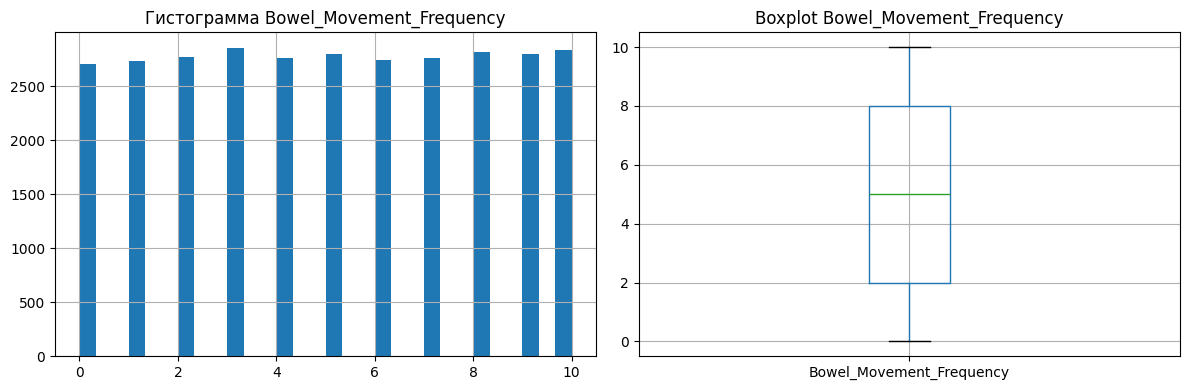

In [29]:
import matplotlib.pyplot as plt

numeric_cols = [
    'Age', 'BMI', 'Body_Weight', 'Genetic_Markers', 'Microbiome_Index',
    'Fecal_Calprotectin', 'CRP_ESR', 'Stress_Level', 'Physical_Activity',
    'Bowel_Movement_Frequency'
]

print("Основная статистика числовых признаков:")
print(df[numeric_cols].describe().T)

print("\nМедианы по числовым признакам:")
for col in numeric_cols:
    median_val = df[col].median()
    print(f"{col}: {median_val}")

for col in numeric_cols:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    df[col].hist(bins=30)
    plt.title(f"Гистограмма {col}")

    plt.subplot(1, 2, 2)
    df.boxplot(column=col)
    plt.title(f"Boxplot {col}")

    plt.tight_layout()
    plt.show()


### Выводы по разделу 5: Семантический анализ

1. Диапазоны и статистики числовых признаков соответствуют логике, аномальных значений не выявлено.
2. Все категориальные столбцы содержат допустимые и осмысленные значения без опечаток.
3. Нарушений бизнес-правил не обнаружено, форматы данных корректны.
4. Графическое распределение данных (гистограммы, boxplot) подтверждает отсутствие крупных выбросов.
5. Датасет готов для дальнейшего анализа и визуализации результатов.


# 6. Визуализация данных


In [30]:
# 6.1. Настройка внешнего вида Plotly-графиков (палитра + шрифт)

import plotly.io as pio
import plotly.express as px

# Главная цветовая палитра
main_palette = ["#275A58", "#30938B", "#7EABA6", "#C5B8BA", "#F4C2CD", "#E2C9D5"]

# Шрифт
font_family = "Roboto"

# Создаём и регистрируем собственный шаблон на основе plotly_white
pio.templates["custom"] = pio.templates["plotly_white"]
pio.templates["custom"]["layout"]["colorway"] = main_palette
pio.templates["custom"]["layout"]["font"] = {"family": font_family, "size": 16}

# Делаем шаблон по умолчанию
pio.templates.default = "custom"

print("Кастомный шаблон Plotly успешно применён!")


Кастомный шаблон Plotly успешно применён!


In [31]:
# 6.2. Гистограмма заболеваемости по полу и статусу ожирения

fig = px.histogram(
    df,
    x="Disease_Class",
    color="Gender",
    facet_col="Obesity_Status",
    barmode="stack",
    color_discrete_sequence=main_palette,
    template="custom",
    title="Распределение классов заболеваний по полу и статусу ожирения"
)
fig.update_layout(height=600, font=dict(family="Roboto", size=16))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) 
fig.show()


In [ ]:
# 6.3. Средний микробиомный индекс по типу диеты и классу заболевания (heatmap)

# Группируем данные: среднее значение микробиомного индекса по комбинациям
# ИСПРАВЛЕНИЕ: Добавлено observed=True, чтобы избежать FutureWarning
heat_df = (
    df.groupby(["Diet_Type", "Disease_Class"], observed=True)["Microbiome_Index"]
    .mean()
    .reset_index()
)

# Строим интерактивную тепловую карту
fig = px.density_heatmap(
    heat_df,
    x="Diet_Type",
    y="Disease_Class",
    z="Microbiome_Index",
    color_continuous_scale="tealrose",
    template="custom",
    title="Средний микробиомный индекс по типу диеты и классу заболевания"
)

# Улучшаем читаемость
fig.update_layout(
    height=600,
    font=dict(family="Roboto", size=16),
    xaxis_title="Тип диеты",
    yaxis_title="Класс заболевания",
)

fig.show()

In [33]:
# 6.4. Количественное распределение пациентов по типу заболевания

# Считаем количество пациентов в каждой группе
disease_counts = df["Disease_Class"].value_counts().reset_index()
disease_counts.columns = ["Disease_Class", "Count"]

fig = px.pie(
    disease_counts,
    names="Disease_Class",
    values="Count",
    color="Disease_Class",  
    color_discrete_sequence=main_palette,
    template="custom",
    title="Распределение пациентов по классам заболеваний"
)

# Внутри секций показываем процент и название
fig.update_traces(textposition="inside", textinfo="percent+label")

# Настройка размера и шрифта
fig.update_layout(
    height=500,
    font=dict(family="Roboto", size=16)
)

fig.show()


In [34]:
# 6.5. Гистограмма использования медицинских препаратов среди пациентов
meds = ["NSAID_Use", "Antibiotic_Use", "PPI_Use", "Medications"]

med_counts = pd.DataFrame()
for med in meds:
    counts = df[med].value_counts().reset_index()
    counts.columns = ["Usage", "Count"]
    counts["Medication"] = med
    med_counts = pd.concat([med_counts, counts], axis=0)

# Строим многослойную гистограмму
fig = px.bar(
    med_counts,
    x="Medication",
    y="Count",
    color="Usage",
    template="custom",
    color_discrete_sequence=[main_palette[0], main_palette[1]],
    title="Использование различных препаратов среди пациентов",
    text="Count"
)

fig.update_layout(
    barmode="stack",
    height=600,
    font=dict(family="Roboto", size=16),
    xaxis_title="Препарат",
    yaxis_title="Количество пациентов"
)

fig.show()


### Выводы по разделу 6: Визуализация данных

Наиболее важным наблюдением является неестественно высокая степень сбалансированности по ключевым признакам:

1. Классы заболеваний: распределение пациентов по шести классам заболеваний является почти идеально равномерным, с долей каждого класса в пределах 16.2% – 17.2%. Это крайне нетипично для реальной клинической выборки, где всегда присутствует выраженное преобладание одних диагнозов над другими.
2. Использование медикаментов: аналогичная, даже более подозрительная, ситуация наблюдается с использованием медицинских препаратов (НПВС, Антибиотики, ИПП). Соотношение пациентов, принимавших (True) и не принимавших (False) каждый вид препарата, составляет практически идеальные 50/50.
3. Микробиомный индекс: Тепловая карта показала, что средний микробиомный индекс в различных сочетаниях диет и заболеваний имеет крайне низкую вариативность (разница между максимальным и минимальным средним значением составляет всего около 0.025). Это говорит о том, что, несмотря на наличие видимых тенденций (например, более низкий индекс при вегетарианской диете), фактическая числовая связь между диетой, заболеванием и индексом в этих данных очень слабая или несущественная.
4. Статус ожирения и пол: Распределение по статусу ожирения является единственным реалистичным паттерном в датасете, демонстрируя ожидаемый сильный перекос в сторону пациентов с ожирением (Obese >> Underweight). При этом в категориях "Obese" и "Normal" наблюдается либо преобладание, либо равенство мужчин и женщин, что, однако, не отменяет общей искусственности остальных распределений.

Такая однородность и высокая степень балансировки по основным целевым и категориальным признакам настоятельно указывает на то, что датасет является синтетическим или был подвергнут агрессивной искусственной балансировке.